# PSO dynamical equations
* velocity update
$$
    v_j^{(i)}[k+1] = w * v_j^{(i)}[k] + c_1 * r_1,j * (p_j^{(i)}[k] - x_j^{(i)}[k]) + c_2 * r_2,j * (g_j^{(i)}[k] - x_j^{(i)}[k])
$$

* position update
$$
    x_j^{(i)}[k+1] = x_j^{(i)}[k] + v_j^{(i)}[k+1]
$$

* $\bar{x}^{(i)}[k]$: Position of $i$th particle in $k$th iteration

$$
    \bar{x}^{(i)}[k] = (x_0^{(i)}[k], x_1^{(i)}[k], ..., x_D^{(i)}[k])
$$

* $\bar{v}^{(i)}[k]$: velocity of $i$th particle in $k$th iteration

$$
    \bar{v}^{(i)}[k] = (v_0^{(i)}[k], v_1^{(i)}[k], ..., v_D^{(i)}[k])
$$

In [1]:
using Plots
using LaTeXStrings

In [2]:
include("../pso.jl")

updateSwarm

## Función de Griewank
**Objetivo: Minimización**

La función de Griewank es una función de prueba comúnmente utilizada en optimización:

$$
f(\mathbf{x}) = 1 + \frac{1}{4000}\sum_{i=1}^{n}x_i^2 - \prod_{i=1}^{n}\cos\left(\frac{x_i}{\sqrt{i}}\right)
$$

* **Mínimo global**: $f(0, 0, ..., 0) = 0$
* **Dominio típico**: $x_i \in [-600, 600]$
* **Características**: Múltiples mínimos locales con un único mínimo global en el origen

In [ ]:
function onePsoRun(fitFunc::Function, nDim::Int; 
                   nParticle=100, nInter::Int=4000,
                   c1::Float64=2.0, c2::Float64=2.0, 
                   wMax::Float64=0.9, wMin::Float64=0.4)
    s = Swarm(fitFunc, nDim, nParticle=nParticle, nInter=nInter,
              c1=c1, c2=c2, wMax=wMax, wMin=wMin)
    initSwarm(s)
    
    for i in s.nInter
        updateSwarm(s)
    end
    s.gBest
end

# Griewank function
function griewank(x)
    sum_term = sum(x.^2) / 4000
    prod_term = prod(cos.(x ./ sqrt.(1:length(x))))
    return 1 + sum_term - prod_term
end

fitFunc = griewank
nDim = 2

# Parámetros del PSO
nParticle = 100
nInter = 4000
c1 = 2.0  # Constante cognitiva (atracción hacia el mejor personal)
c2 = 4 - c1  # Constante social (atracción hacia el mejor global)
wMax = 0.9  # Peso de inercia máximo

nRun = 200
xs = Array{Float64}(undef, nRun)
ys = zeros(nRun)

# Medir el tiempo de ejecución
tiempo_total = @elapsed begin
    for i in 1:nRun
        xs[i], ys[i] = onePsoRun(fitFunc, nDim, nParticle=nParticle, nInter=nInter,
                                  c1=c1, c2=c2, wMax=wMax)
    end
end

# Imprimir el tiempo
println("Tiempo total de ejecución: $(round(tiempo_total, digits=3)) segundos")
println("Tiempo promedio por corrida: $(round(tiempo_total/nRun, digits=4)) segundos")

Tiempo total de ejecución: 0.3 segundos
Tiempo promedio por corrida: 0.0015 segundos


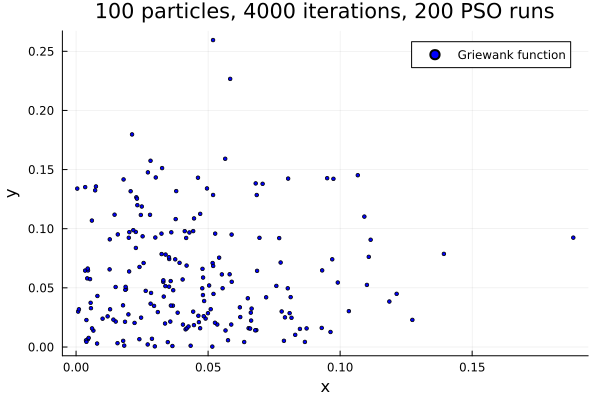

In [5]:
gr()
scatter(xs, ys, markersize=2, c=:blue, 
label = "Griewank function",
title = "$nParticle particles, $nInter iterations, $nRun PSO runs")
xlabel!("x")
ylabel!("y")

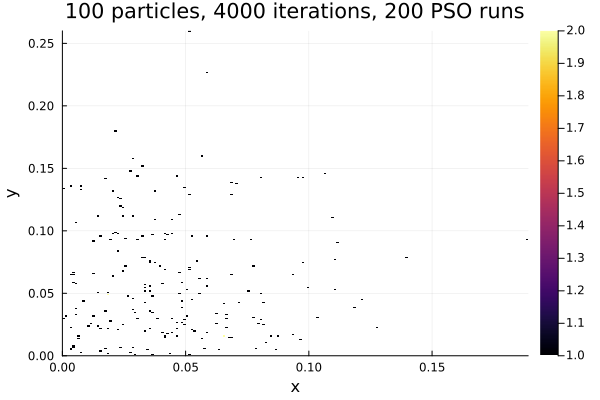

In [6]:
histogram2d(xs, ys, nbins=300, 
label = "Griewank function",
title = "$nParticle particles, $nInter iterations, $nRun PSO runs")
xlabel!("x")
ylabel!("y")

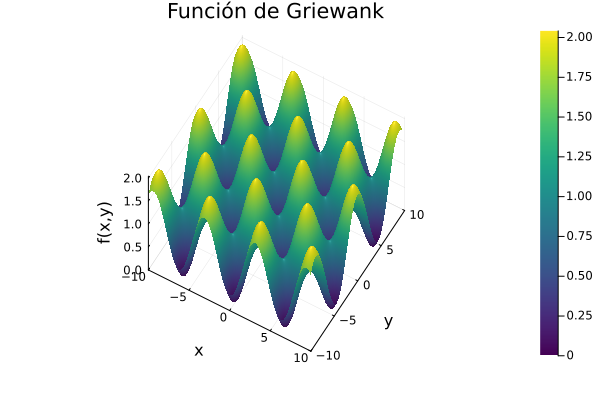

In [7]:
# Plot 3D de la función de Griewank
x_range = -10:0.1:10
y_range = -10:0.1:10

z = [griewank([x, y]) for y in y_range, x in x_range]

surface(x_range, y_range, z, 
    xlabel="x", ylabel="y", zlabel="f(x,y)",
    title="Función de Griewank",
    camera=(30, 60),
    c=:viridis)

## Animación del proceso de optimización

La siguiente animación muestra cómo las partículas del enjambre se mueven a través del espacio de búsqueda para encontrar el mínimo de la función de Griewank.

[ Info: Saved animation to /home/fabian/Projects/github/FundamentosDeOptimizacion/PSO/examples/pso_griewank_animation.gif


Plots.AnimatedGif("/home/fabian/Projects/github/FundamentosDeOptimizacion/PSO/examples/pso_griewank_animation.gif")
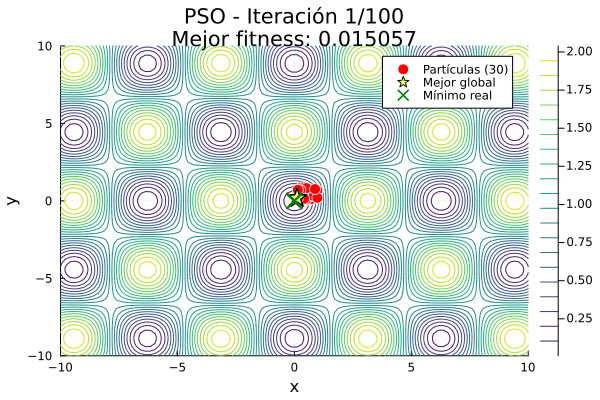

In [8]:
# Animación del PSO buscando el mínimo de la función de Griewank
function animatePSO(fitFunc::Function, nDim::Int; 
                     nParticle=30, nInter::Int=100, 
                     xlims=(-10, 10), ylims=(-10, 10))
    
    # Crear el enjambre
    s = Swarm(fitFunc, nDim, nParticle=nParticle, nInter=nInter)
    initSwarm(s)
    
    # Crear el mapa de calor de la función
    x_range = range(xlims[1], xlims[2], length=100)
    y_range = range(ylims[1], ylims[2], length=100)
    z = [fitFunc([x, y]) for y in y_range, x in x_range]
    
    # Crear la animación
    anim = @animate for iter in 1:nInter
        # Plot del contorno de la función
        contour(x_range, y_range, z, 
                levels=20, 
                c=:viridis, 
                colorbar=true,
                xlims=xlims, ylims=ylims,
                xlabel="x", ylabel="y",
                title="PSO - Iteración $iter/$nInter\nMejor fitness: $(round(s.fitgBest, digits=6))",
                legend=:topright)
        
        # Extraer posiciones de todas las partículas
        xs_particles = [p.position[1] for p in s.particles]
        ys_particles = [p.position[2] for p in s.particles]
        
        # Plot de las partículas
        scatter!(xs_particles, ys_particles, 
                 markersize=6, 
                 markercolor=:red, 
                 markerstrokewidth=1,
                 markerstrokecolor=:white,
                 label="Partículas ($nParticle)")
        
        # Plot del mejor global
        scatter!([s.gBest[1]], [s.gBest[2]], 
                 markersize=10, 
                 markercolor=:yellow,
                 markershape=:star5,
                 markerstrokewidth=2,
                 markerstrokecolor=:black,
                 label="Mejor global")
        
        # Plot del mínimo verdadero (origen)
        scatter!([0], [0], 
                 markersize=8, 
                 markercolor=:green,
                 markershape=:xcross,
                 markerstrokewidth=3,
                 label="Mínimo real")
        
        # Actualizar el enjambre para la siguiente iteración
        if iter < nInter
            updateSwarm(s)
        end
    end
    
    return anim, s
end

# Ejecutar la animación
anim, s_final = animatePSO(griewank, 2, nParticle=30, nInter=100, xlims=(-10, 10), ylims=(-10, 10))

# Guardar como GIF
gif(anim, "pso_griewank_animation.gif", fps=10)

In [9]:
# Mostrar el resultado final
println("Mejor posición encontrada: ", s_final.gBest)
println("Mejor fitness encontrado: ", s_final.fitgBest)
println("Distancia al mínimo real (0,0): ", sqrt(sum(s_final.gBest.^2)))

Mejor posición encontrada: [0.0011096110123743341, 0.024558609133419264]
Mejor fitness encontrado: 0.0001515441460571143
Distancia al mínimo real (0,0): 0.02458366366445096
